Download data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-18 19:16:44--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.7, 13.249.85.10, 13.249.85.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2023-03-18 19:16:44 (39.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.

In [2]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 5 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [7]:
MAX_LENGTH = 5

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, max_length = MAX_LENGTH):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs, max_length=MAX_LENGTH):
    return [pair for pair in pairs if filterPair(pair,max_length)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, reverse=False,max_length=MAX_LENGTH):
    print(max_length)
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, max_length)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True, max_length=MAX_LENGTH)
random.shuffle(pairs)
train_data = pairs[0:int(math.floor(0.8*len(pairs)))]
validation_data = pairs[int(math.floor(0.8*len(pairs)))+1:int(math.floor(0.9*len(pairs)))]
test_data = pairs[int(math.floor(0.9*len(pairs)))+1:]

print(random.choice(pairs))

5
Reading lines...
Read 135842 sentence pairs
Trimmed to 1404 sentence pairs
Counting words...
Counted words:
fra 940
eng 466
['vous etes extravertie .', 'you re extroverted .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        if isinstance(decoder, DecoderRNN):
          for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
        else:
          for di in range(target_length):
              decoder_output, decoder_hidden, decoder_attention = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
              loss += criterion(decoder_output, target_tensor[di])
              decoder_input = target_tensor[di]  # Teacher forcing
        

    else:
        if isinstance(decoder, DecoderRNN):
          for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
        else:
        # Without teacher forcing: use its own predictions as the next input
          for di in range(target_length):
              decoder_output, decoder_hidden, decoder_attention = decoder(
                  decoder_input, decoder_hidden, encoder_outputs)
              topv, topi = decoder_output.topk(1)
              decoder_input = topi.squeeze().detach()  # detach from history as input

              loss += criterion(decoder_output, target_tensor[di])
              if decoder_input.item() == EOS_token:
                  break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    if isinstance(decoder, DecoderRNN):
      for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    # Without teacher forcing: use its own predictions as the next input
    else:
      for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset(dataset, encoder, decoder, criterion, max_length):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval(input_tensor, target_tensor, encoder, decoder, criterion, max_length)
    return loss / len(dataset)


The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [15]:

def trainIters(encoder, decoder, n_iters, print_every=2000, plot_every=1000, max_length = MAX_LENGTH):
    start = time.time()
    all_train_losses = []
    all_validation_losses = []
    train_loss = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss = eval_dataset(validation_data, encoder, decoder, criterion, max_length)

            # save model with best validation loss
            if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
                if isinstance(decoder, DecoderRNN):
                  torch.save(encoder, 'seq2seq_translation_encoder_model.pt')
                  torch.save(decoder, 'seq2seq_translation_decoder_model.pt')
                else:
                  torch.save(encoder, 'seq2seq_translation_encoder_model.pt')
                  torch.save(decoder, 'seq2seq_translation_attn_decoder_model.pt')
            all_validation_losses.append(average_validation_loss)
    return all_train_losses, all_validation_losses       
    

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(all_train_losses, all_validation_losses, all_train_losses_att, all_validation_losses_att, all_train_losses_trans, all_validation_losses_trans):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(all_train_losses_att, label = "rnn with attention")
    plt.plot(all_train_losses, label = "rnn without attention")
    plt.plot(all_train_losses_trans, label = "transformer")
    plt.title('Seq2seq translation (training loss)')
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend(loc='upper right')

    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(all_validation_losses_att, label = "rnn with attention")
    plt.plot(all_validation_losses, label = "rnn without attention")
    plt.plot(all_validation_losses_trans, label = "transformer")
    plt.title('Seq2seq translation (validation loss)')
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend(loc='upper right')


Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 32 hidden nodes and a
single GRU layer. 

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [19]:
hidden_size = 32
MAX_LENGTH = 5
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, max_length = MAX_LENGTH).to(device)

train_losses_att, val_losses_att = trainIters(encoder, attn_decoder, 30000, max_length = MAX_LENGTH)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model.pt')
attn_decoder = torch.load('seq2seq_translation_attn_decoder_model.pt')
average_test_loss = eval_dataset(test_data, encoder, attn_decoder, nn.NLLLoss(), MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 32s) 	1.4570
4000 	13% 	(1m 2s) 	1.2323
6000 	20% 	(1m 33s) 	1.1337
8000 	26% 	(2m 3s) 	1.0667
10000 	33% 	(2m 33s) 	1.0300
12000 	40% 	(3m 3s) 	0.9934
14000 	46% 	(3m 32s) 	0.9430
16000 	53% 	(4m 2s) 	0.8993
18000 	60% 	(4m 32s) 	0.8631
20000 	66% 	(5m 8s) 	0.8280
22000 	73% 	(5m 39s) 	0.7790
24000 	80% 	(6m 9s) 	0.7490
26000 	86% 	(6m 39s) 	0.7375
28000 	93% 	(7m 9s) 	0.6788
30000 	100% 	(7m 39s) 	0.6661
Average test loss: 1.3924652011053904


In [20]:
evaluateRandomly(encoder, attn_decoder)

> vous etes pathetiques .
= you re pathetic .
< you re big . <EOS>

> vous etes bougon .
= you re grumpy .
< you re crafty . <EOS>

> tu temporises .
= you re stalling .
< you re lying . <EOS>

> tu viens tot .
= you are early .
< you re crafty . <EOS>

> je suis sensible .
= i m sensitive .
< i m exhausted . <EOS>

> vous etes paresseux .
= you re lazy .
< you re big . <EOS>

> ils sont medecins .
= they are doctors .
< they re exhausted . <EOS>

> vous etes connu .
= you re famous .
< you re big . <EOS>

> je suis creve .
= i m exhausted .
< i m exhausted . <EOS>

> je suis gene .
= i m embarrassed .
< i m exhausted . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [21]:
# output_words, attentions = evaluate(encoder, attn_decoder, "je suis trop froid .")
# plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [22]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + input_sentence.split(' ') +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(
#         encoder, attn_decoder, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("elle a cinq ans de moins que moi .")

# evaluateAndShowAttention("elle est trop petit .")

# evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




### Training a seq2seq RNN without Attention (Max Length 5)

In [23]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
MAX_LENGTH = 5
train_losses, val_losses = trainIters(encoder, decoder, 30000, max_length = MAX_LENGTH)
# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model.pt')
decoder = torch.load('seq2seq_translation_decoder_model.pt')
average_test_loss = eval_dataset(test_data, encoder, decoder, nn.NLLLoss(), MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 20s) 	1.5015
4000 	13% 	(0m 40s) 	1.2142
6000 	20% 	(1m 0s) 	1.1491
8000 	26% 	(1m 20s) 	1.0951
10000 	33% 	(1m 40s) 	1.0435
12000 	40% 	(1m 59s) 	0.9898
14000 	46% 	(2m 19s) 	0.9332
16000 	53% 	(2m 39s) 	0.8885
18000 	60% 	(2m 59s) 	0.8593
20000 	66% 	(3m 19s) 	0.7989
22000 	73% 	(3m 38s) 	0.7606
24000 	80% 	(3m 58s) 	0.7258
26000 	86% 	(4m 18s) 	0.7093
28000 	93% 	(4m 38s) 	0.6738
30000 	100% 	(4m 57s) 	0.6663
Average test loss: 1.41557557957513


### Seq2Seq using Transformer (Max Length 5)

In [24]:
from torch import Tensor

from torch.nn import Transformer

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, hidden_size, 2)* math.log(10000) / hidden_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, hidden_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, hidden_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.hidden_size)


In [25]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 hidden_size: int,
                 nhead: int,
                 input_size: int,
                 output_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=hidden_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(hidden_size, output_size)
        self.src_tok_emb = TokenEmbedding(input_size, hidden_size)
        self.tgt_tok_emb = TokenEmbedding(output_size, hidden_size)
        self.positional_encoding = PositionalEncoding(
            hidden_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        memory = self.transformer.encoder(src_emb, src_mask)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


In [26]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    diag_mask = torch.eye(sz, device=device).type(torch.bool)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    return src_mask, tgt_mask


In [27]:
def trainIters_transformer(transformer, n_iters, print_every=2000, plot_every=1000, max_length = MAX_LENGTH):
    start = time.time()
    all_train_losses = []
    all_validation_losses = []
    train_loss = 0  # Reset every plot_every

    transformer_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)
    training_pairs = [tensorsFromPair(random.choice(train_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_transformer(input_tensor, target_tensor, transformer, transformer_optimizer, criterion, max_length)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss = eval_dataset_transformer(validation_data, transformer, criterion, max_length)

            # save model with best validation loss
            if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
                  torch.save(transformer, 'seq2seq_translation_transformer_model.pt')
                  
            all_validation_losses.append(average_validation_loss)
            
    return all_train_losses, all_validation_losses

In [28]:
def train_transformer(input_tensor, target_tensor, transformer, transformer_optimizer, criterion, max_length=MAX_LENGTH):
  transformer.train()
  transformer_optimizer.zero_grad()
  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)
  loss = 0
  sos_token = torch.tensor([[SOS_token]], device=device)
  
  target_tensor = torch.cat((sos_token, target_tensor[:-1]), dim=0) 
  src_mask, tgt_mask = create_mask(input_tensor, target_tensor)
  output = transformer(input_tensor, target_tensor, src_mask, tgt_mask)
  output = F.log_softmax(output,dim=-1)

  target_with_eos = torch.cat((target_tensor, torch.tensor([EOS_token], device=device).unsqueeze(0)))
  loss = criterion(output.view(-1, output.size(-1)), target_with_eos[1:].view(-1))
  loss.backward()
  transformer_optimizer.step()
  return loss.item() / target_length

In [29]:
def eval_transformer(input_tensor, target_tensor, transformer, criterion, max_length=MAX_LENGTH):
    transformer.eval()
    with torch.no_grad():
      input_length = input_tensor.size(0)
      target_length = target_tensor.size(0)
      loss = 0
      sos_token = torch.tensor([[SOS_token]], device=device)
      target_tensor = torch.cat((sos_token, target_tensor[:-1]), dim=0) 
      src_mask, tgt_mask = create_mask(input_tensor, target_tensor)
      output = transformer(input_tensor, target_tensor, src_mask, tgt_mask)
      output = F.log_softmax(output,dim=-1)

      target_with_eos = torch.cat((target_tensor, torch.tensor([EOS_token], device=device).unsqueeze(0)))
      loss = criterion(output.view(-1, output.size(-1)), target_with_eos[1:].view(-1))

    return loss.item() / target_length

def eval_dataset_transformer(dataset, transformer, criterion, max_length = MAX_LENGTH):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_transformer(input_tensor, target_tensor, transformer, criterion, max_length)
    return loss / len(dataset)

In [30]:
hidden_size = 32
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
MAX_LENGTH = 5
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, hidden_size,
                                 NHEAD, input_lang.n_words, output_lang.n_words, FFN_HID_DIM).to(device)
for p in transformer.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p)
transformer = transformer.to(device)
train_losses_trans, val_losses_trans = trainIters_transformer(transformer, 30000, max_length = MAX_LENGTH)

transformer = torch.load('seq2seq_translation_transformer_model.pt')
average_test_loss = eval_dataset_transformer(test_data, transformer, nn.NLLLoss(), max_length = MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))



Iter 	Train% 	Time 		Train_loss
2000 	6% 	(1m 5s) 	0.4827
4000 	13% 	(2m 9s) 	0.3217
6000 	20% 	(3m 14s) 	0.2855
8000 	26% 	(4m 18s) 	0.2573
10000 	33% 	(5m 23s) 	0.2492
12000 	40% 	(6m 27s) 	0.2407
14000 	46% 	(7m 31s) 	0.2343
16000 	53% 	(8m 35s) 	0.2283
18000 	60% 	(9m 39s) 	0.2187
20000 	66% 	(10m 43s) 	0.2138
22000 	73% 	(11m 48s) 	0.2035
24000 	80% 	(12m 52s) 	0.1975
26000 	86% 	(13m 56s) 	0.1886
28000 	93% 	(15m 0s) 	0.1791
30000 	100% 	(16m 5s) 	0.1727
Average test loss: 0.23271351814270014


For sequences of max length 5:


<Figure size 432x288 with 0 Axes>

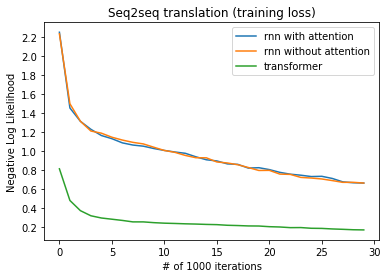

<Figure size 432x288 with 0 Axes>

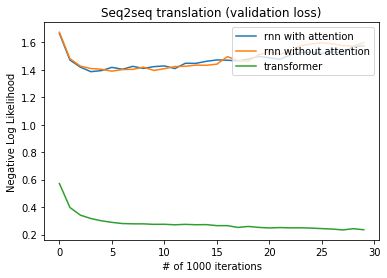

In [31]:
print('For sequences of max length 5:')
showPlot(train_losses, val_losses, train_losses_att, val_losses_att, train_losses_trans, val_losses_trans)

In [32]:
def evaluate_transformer(transformer, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        src_mask = torch.zeros((input_length, input_length),device=device).type(torch.bool)
        encoder_outputs = transformer.encode(input_tensor, src_mask)
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoded_words = []
        for i in range(max_length):
          tgt_mask = (generate_square_subsequent_mask(decoder_input.size(0)).type(torch.bool)).to(device)
          output = transformer.decode(decoder_input, encoder_outputs, tgt_mask)
          output = transformer.generator(output.transpose(0,1)[:, -1])
          _, next_word = torch.max(output, dim=1)
          next_word = next_word.item()
          if next_word == EOS_token:
            decoded_words.append('<EOS>')
            break
          else:
            decoded_words.append(output_lang.index2word[next_word])
            decoder_input = torch.cat([decoder_input,torch.ones(1, 1).type_as(input_tensor.data).fill_(next_word)], dim=0)
        return decoded_words

In [33]:
def evaluateRandomly_transformer(transformer, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate_transformer(transformer, pair[0], MAX_LENGTH)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [34]:
evaluateRandomly_transformer(transformer)

> on se gele .
= we re freezing .
< we re shaken . <EOS>

> elle est obstinee .
= she is stubborn .
< she is strong . <EOS>

> vous etes puissante .
= you re powerful .
< you re good . <EOS>

> tu es endurante .
= you re resilient .
< you re good . <EOS>

> je suis humain .
= i am human .
< i m lucky . <EOS>

> tu es bavard .
= you re talkative .
< you re talkative . <EOS>

> nous sommes devoues .
= we re dedicated .
< we re ruthless . <EOS>

> vous etes productif .
= you re productive .
< you re productive . <EOS>

> vous etes invitee .
= you re invited .
< you re funny . <EOS>

> je suis puissante .
= i m powerful .
< i m resilient . <EOS>



### Training a seq2seq RNN with Attention (Max Length 10)

In [35]:
MAX_LENGTH = 10
input_lang, output_lang, pairs = prepareData('eng', 'fra', True, MAX_LENGTH)
random.shuffle(pairs)
train_data = pairs[0:int(math.floor(0.8*len(pairs)))]
validation_data = pairs[int(math.floor(0.8*len(pairs)))+1:int(math.floor(0.9*len(pairs)))]
test_data = pairs[int(math.floor(0.9*len(pairs)))+1:]

print(random.choice(pairs))

10
Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['vous etes tres grandes .', 'you re very tall .']


In [36]:
hidden_size = 32
MAX_LENGTH = 10
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, max_length = MAX_LENGTH).to(device)
train_losses_att, val_losses_att = trainIters(encoder, attn_decoder, 30000, max_length = MAX_LENGTH)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model.pt')
attn_decoder = torch.load('seq2seq_translation_attn_decoder_model.pt')
average_test_loss = eval_dataset(test_data, encoder, attn_decoder, nn.NLLLoss(), max_length = MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 44s) 	3.2077
4000 	13% 	(1m 37s) 	2.9847
6000 	20% 	(2m 29s) 	2.8141
8000 	26% 	(3m 22s) 	2.6696
10000 	33% 	(4m 15s) 	2.5597
12000 	40% 	(5m 7s) 	2.5109
14000 	46% 	(6m 1s) 	2.4157
16000 	53% 	(6m 54s) 	2.3768
18000 	60% 	(7m 47s) 	2.2985
20000 	66% 	(8m 41s) 	2.2726
22000 	73% 	(9m 34s) 	2.2766
24000 	80% 	(10m 27s) 	2.2043
26000 	86% 	(11m 20s) 	2.1918
28000 	93% 	(12m 13s) 	2.1523
30000 	100% 	(13m 6s) 	2.2028
Average test loss: 2.649848942973779


### Training a seq2seq RNN without Attention (Max Length 10)

In [37]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
MAX_LENGTH = 10
train_losses, val_losses = trainIters(encoder, decoder, 30000,max_length = MAX_LENGTH)

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model.pt')
decoder = torch.load('seq2seq_translation_decoder_model.pt')
average_test_loss = eval_dataset(test_data, encoder, decoder, nn.NLLLoss(), max_length=MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))




Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 29s) 	3.2274
4000 	13% 	(1m 3s) 	2.9466
6000 	20% 	(1m 38s) 	2.8617
8000 	26% 	(2m 12s) 	2.7301
10000 	33% 	(2m 47s) 	2.6621
12000 	40% 	(3m 22s) 	2.6015
14000 	46% 	(3m 57s) 	2.5600
16000 	53% 	(4m 32s) 	2.5052
18000 	60% 	(5m 7s) 	2.4544
20000 	66% 	(5m 42s) 	2.4440
22000 	73% 	(6m 17s) 	2.3397
24000 	80% 	(6m 53s) 	2.4049
26000 	86% 	(7m 28s) 	2.3765
28000 	93% 	(8m 4s) 	2.3814
30000 	100% 	(8m 39s) 	2.3786
Average test loss: 2.817257958147018


### Seq2Seq using Transformer (Max Length 10)

In [38]:
hidden_size = 32
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
MAX_LENGTH = 10
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, hidden_size,
                                 NHEAD, input_lang.n_words, output_lang.n_words, FFN_HID_DIM).to(device)
for p in transformer.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p)
transformer = transformer.to(device)
train_losses_trans, val_losses_trans = trainIters_transformer(transformer, 30000, max_length = MAX_LENGTH)

transformer = torch.load('seq2seq_translation_transformer_model.pt')
average_test_loss = eval_dataset_transformer(test_data, transformer, nn.NLLLoss(), max_length = MAX_LENGTH)
print('Average test loss: ' + str(average_test_loss))



Iter 	Train% 	Time 		Train_loss
2000 	6% 	(1m 13s) 	0.6404
4000 	13% 	(2m 32s) 	0.4940
6000 	20% 	(3m 52s) 	0.4398
8000 	26% 	(5m 12s) 	0.4204
10000 	33% 	(6m 32s) 	0.3876
12000 	40% 	(7m 51s) 	0.3703
14000 	46% 	(9m 11s) 	0.3687
16000 	53% 	(10m 31s) 	0.3547
18000 	60% 	(11m 51s) 	0.3460
20000 	66% 	(13m 10s) 	0.3383
22000 	73% 	(14m 30s) 	0.3293
24000 	80% 	(15m 49s) 	0.3229
26000 	86% 	(17m 10s) 	0.3221
28000 	93% 	(18m 29s) 	0.3133
30000 	100% 	(19m 48s) 	0.3037
Average test loss: 0.3220331507387131


In [39]:
evaluateRandomly_transformer(transformer)

> vous etes avide .
= you re greedy .
< you re very timid . <EOS>

> elles sont en train d arriver .
= they re coming .
< they re all ! <EOS>

> tu es le chef .
= you re the leader .
< you re the teacher . <EOS>

> tu es tranquille .
= you re quiet .
< you re arrogant . <EOS>

> vous etes liberes de toute responsabilite .
= you re free of all responsibility .
< you re all going to be . <EOS>

> il est faineant .
= he is lazy .
< he is a adult . <EOS>

> j ai deja termine .
= i m already done .
< i m all all . <EOS>

> tu te comportes comme un petit enfant .
= you re acting like a small child .
< you re going to be a teacher . <EOS>

> tu es un veritable ami .
= you re a true friend .
< you re a teacher . <EOS>

> nous sommes des nouvelles venues .
= we re newcomers .
< we re going to help . <EOS>



For sequences of max length 10:


<Figure size 432x288 with 0 Axes>

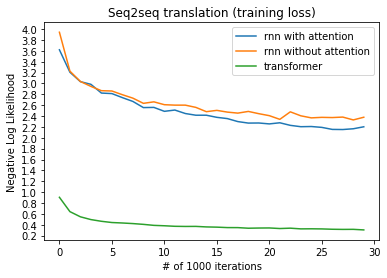

<Figure size 432x288 with 0 Axes>

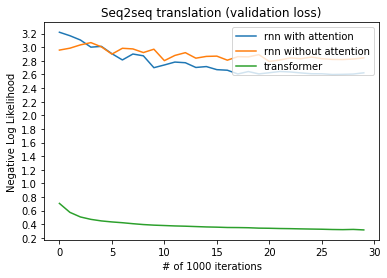

In [40]:
print('For sequences of max length 10:')
showPlot(train_losses, val_losses, train_losses_att, val_losses_att, train_losses_trans, val_losses_trans)

For comparing the seq2seq RNNs with and without attention, we notice that for maximum length 5, the performance is fairly similar, whereas for length 10, seq2seq RNN with attention performs better than the one without attention.  The attention mechanism allows the decoder to focus on different parts of the input sequence at each time step, effectively allowing the decoder to attend to the parts of the input sequence that are most relevant to generating the output sequence. It can improve the performance of seq2seq models, particularly for longer input sequences.

The transformer architecture, which uses self-attention instead of recurrent units, is particularly effective for sequence-to-sequence tasks and outperforms traditional RNN-based seq2seq models with attention by a huge margin. The transformer does not require sequential processing, which can lead to faster training times, and it is also less prone to vanishing gradients and other issues that can occur with deep RNNs.


When testing the models on sentences of MAX_LENGTH=5, the differences in performance between the models was not as pronounced, as the sequences are relatively short. However, when testing on sentences of MAX_LENGTH=10, the advantages of the attention mechanism and the transformer architecturebecame more apparent.